In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'Full Cycle LSTM Time Series'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Full Cycle Stock Data

full cycle data\0_acc_data.csv
            previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2000-01-21    17.562500  18.182877 -82.786885 -348800.0     2.0
2000-01-24    17.875000  18.135511 -64.957265 -264800.0     2.0
2000-01-25    17.546875  18.044952 -82.905983 -350800.0     2.0
2000-01-26    17.328125  17.934671 -94.871795 -460000.0     2.0
2000-01-27    17.250000  17.829337 -93.548387 -540800.0     2.0


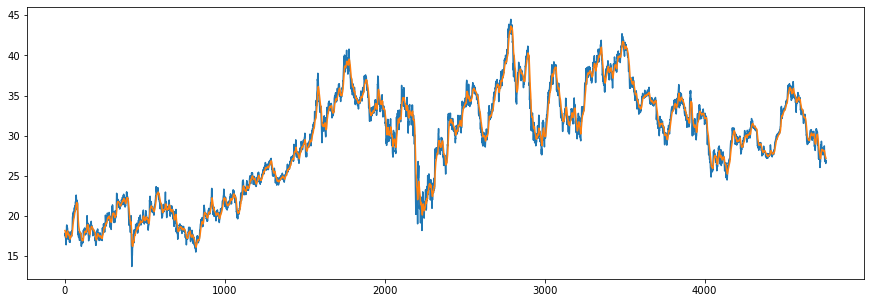

In [5]:
labels = []
sequential = []

for filepath in glob.iglob('full cycle data/*_acc_data.csv'):
    print(filepath)
    seed = 10
    df = pd.read_csv(filepath)
    df.set_index('Date', inplace=True)
    print(df.head())
    
    plt.figure(figsize=(15,5))
    plt.plot(df['previous_1d'].values)
    plt.plot(df['EMA_12'].values)
    plt.show()

    data_15 = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1

In [6]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
X.shape

(4745, 15, 4)

In [7]:
y = labels
y = np.array(y)
y.shape

(4745,)

In [8]:
from collections import Counter

Counter(y)

Counter({2.0: 4314, 1.0: 216, 0.0: 215})

In [9]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [10]:
SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "Close"

In [11]:
import time

EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [12]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [14]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 1 ... 1 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 32ms/step - loss: 0.2942 - accuracy: 0.5034 - mse: 0.4561 - weighted_accuracy: 0.2909 - weighted_mse: 0.5361 - val_loss: 0.2992 - val_accuracy: 0.0443 - val_mse: 0.3551 - val_weighted_accuracy: 0.0443 - val_weighted_mse: 0.3551
Epoch 2/200
30/30 [==============================] - 0s 8ms/step - loss: 0.2093 - accuracy: 0.3319 - mse: 0.7940 - weighted_accuracy: 0.4392 - weighted_mse: 0.7713 - val_loss: 0.2909 - val_accuracy: 0.0453 - val_mse: 0.3858 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3858
Epoch 3/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1874 - accuracy: 0.2479 - mse: 1.0622 - weighted_accuracy: 0.4893 - weighted_mse: 1.0199 - val_loss: 0.2809 - val_accuracy: 0.0453 - val_mse: 0.4252 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.4252
Epoch 4/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1795 - accuracy: 0.2690 - mse: 1.1893 - weighted_accuracy: 0.5043 - weighte

Epoch 30/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1347 - accuracy: 0.4376 - mse: 1.6522 - weighted_accuracy: 0.7130 - weighted_mse: 1.5762 - val_loss: 0.1818 - val_accuracy: 0.4236 - val_mse: 1.6684 - val_weighted_accuracy: 0.4236 - val_weighted_mse: 1.6684
Epoch 31/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1343 - accuracy: 0.4310 - mse: 1.7110 - weighted_accuracy: 0.7216 - weighted_mse: 1.6169 - val_loss: 0.1836 - val_accuracy: 0.4226 - val_mse: 1.7371 - val_weighted_accuracy: 0.4226 - val_weighted_mse: 1.7371
Epoch 32/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1339 - accuracy: 0.4360 - mse: 1.6951 - weighted_accuracy: 0.7161 - weighted_mse: 1.6174 - val_loss: 0.2011 - val_accuracy: 0.3678 - val_mse: 1.7194 - val_weighted_accuracy: 0.3678 - val_weighted_mse: 1.7194
Epoch 33/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1337 - accuracy: 0.4594 - mse: 1.7089 - weighted_accuracy: 0.7026 - weig

Epoch 59/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1091 - accuracy: 0.5914 - mse: 2.1784 - weighted_accuracy: 0.8116 - weighted_mse: 2.1273 - val_loss: 0.1747 - val_accuracy: 0.5058 - val_mse: 2.2141 - val_weighted_accuracy: 0.5058 - val_weighted_mse: 2.2141
Epoch 60/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1086 - accuracy: 0.5964 - mse: 2.1816 - weighted_accuracy: 0.8190 - weighted_mse: 2.1120 - val_loss: 0.1643 - val_accuracy: 0.5711 - val_mse: 2.3180 - val_weighted_accuracy: 0.5711 - val_weighted_mse: 2.3180
Epoch 61/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1062 - accuracy: 0.6035 - mse: 2.2167 - weighted_accuracy: 0.8179 - weighted_mse: 2.1516 - val_loss: 0.1855 - val_accuracy: 0.4847 - val_mse: 2.3686 - val_weighted_accuracy: 0.4847 - val_weighted_mse: 2.3686
Epoch 62/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1061 - accuracy: 0.6048 - mse: 2.2356 - weighted_accuracy: 0.8294 - weig

Epoch 88/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0863 - accuracy: 0.7097 - mse: 2.9502 - weighted_accuracy: 0.8679 - weighted_mse: 2.8692 - val_loss: 0.1758 - val_accuracy: 0.5859 - val_mse: 3.1580 - val_weighted_accuracy: 0.5859 - val_weighted_mse: 3.1580
Epoch 89/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0845 - accuracy: 0.7129 - mse: 2.9506 - weighted_accuracy: 0.8800 - weighted_mse: 2.8734 - val_loss: 0.1822 - val_accuracy: 0.5827 - val_mse: 3.2322 - val_weighted_accuracy: 0.5827 - val_weighted_mse: 3.2322
Epoch 90/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0853 - accuracy: 0.7355 - mse: 3.0582 - weighted_accuracy: 0.8755 - weighted_mse: 2.9960 - val_loss: 0.2004 - val_accuracy: 0.5100 - val_mse: 3.1105 - val_weighted_accuracy: 0.5100 - val_weighted_mse: 3.1105
Epoch 91/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0858 - accuracy: 0.7063 - mse: 3.0139 - weighted_accuracy: 0.8611 - weig

Epoch 117/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0677 - accuracy: 0.7835 - mse: 4.0541 - weighted_accuracy: 0.9096 - weighted_mse: 3.8344 - val_loss: 0.1848 - val_accuracy: 0.6344 - val_mse: 4.1671 - val_weighted_accuracy: 0.6344 - val_weighted_mse: 4.1671
Epoch 118/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0652 - accuracy: 0.7943 - mse: 4.0759 - weighted_accuracy: 0.9135 - weighted_mse: 3.8559 - val_loss: 0.1537 - val_accuracy: 0.7366 - val_mse: 4.6287 - val_weighted_accuracy: 0.7366 - val_weighted_mse: 4.6287
Epoch 119/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0648 - accuracy: 0.8090 - mse: 4.1474 - weighted_accuracy: 0.9226 - weighted_mse: 3.9470 - val_loss: 0.1655 - val_accuracy: 0.6860 - val_mse: 4.6733 - val_weighted_accuracy: 0.6860 - val_weighted_mse: 4.6733
Epoch 120/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0635 - accuracy: 0.7977 - mse: 4.2230 - weighted_accuracy: 0.9148 - 

Epoch 146/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0517 - accuracy: 0.8469 - mse: 5.5460 - weighted_accuracy: 0.9402 - weighted_mse: 5.0466 - val_loss: 0.1871 - val_accuracy: 0.6923 - val_mse: 5.9620 - val_weighted_accuracy: 0.6923 - val_weighted_mse: 5.9620
Epoch 147/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0494 - accuracy: 0.8577 - mse: 5.6203 - weighted_accuracy: 0.9405 - weighted_mse: 5.1830 - val_loss: 0.1667 - val_accuracy: 0.7482 - val_mse: 6.3665 - val_weighted_accuracy: 0.7482 - val_weighted_mse: 6.3665
Epoch 148/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0509 - accuracy: 0.8533 - mse: 5.6138 - weighted_accuracy: 0.9297 - weighted_mse: 5.1251 - val_loss: 0.1729 - val_accuracy: 0.7366 - val_mse: 6.5950 - val_weighted_accuracy: 0.7366 - val_weighted_mse: 6.5950
Epoch 149/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0500 - accuracy: 0.8572 - mse: 5.7290 - weighted_accuracy: 0.9366 - 

Epoch 175/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0399 - accuracy: 0.8970 - mse: 7.3806 - weighted_accuracy: 0.9604 - weighted_mse: 6.4713 - val_loss: 0.1812 - val_accuracy: 0.7629 - val_mse: 7.7684 - val_weighted_accuracy: 0.7629 - val_weighted_mse: 7.7684
Epoch 176/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0391 - accuracy: 0.8928 - mse: 7.4462 - weighted_accuracy: 0.9607 - weighted_mse: 6.5267 - val_loss: 0.1828 - val_accuracy: 0.7798 - val_mse: 8.4746 - val_weighted_accuracy: 0.7798 - val_weighted_mse: 8.4746
Epoch 177/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0380 - accuracy: 0.8965 - mse: 7.5884 - weighted_accuracy: 0.9565 - weighted_mse: 6.6325 - val_loss: 0.1937 - val_accuracy: 0.7376 - val_mse: 7.9093 - val_weighted_accuracy: 0.7376 - val_weighted_mse: 7.9093
Epoch 178/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0432 - accuracy: 0.8801 - mse: 7.6101 - weighted_accuracy: 0.9487 - 

In [15]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.21088074147701263
Test accuracy: 0.773445725440979


In [16]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.6360838  -5.412696    1.1429969 ]
 [-3.3751018  -7.4089065   3.9615016 ]
 [-0.8480621  -2.7990673   0.13959421]
 ...
 [-1.6801549  -3.390279    0.86732805]
 [-0.26125777 -4.980533   -0.15467384]
 [-2.925276   -0.9892105  -0.833511  ]]


Counter({2: 803, 0: 88, 1: 58})

In [17]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 863, 0: 43, 1: 43})

In [18]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 949
actual predicted buys: 4
actual buys but predicted sell: 3
actual buys but predicted hold: 36
actual sells but predicted buy: 2
actual predicted sells: 2
actual sells but predicted hold: 39
actual holds but predicted buy: 52
actual holds but predicted sell: 83
actual predicted holds: 728
Percentage buys correct: 9.30232558139535%
Percentage sells correct: 4.651162790697675%
Percentage holds correct: 84.3568945538818%
actual buys: 43
actual sells: 43
actual holds: 863


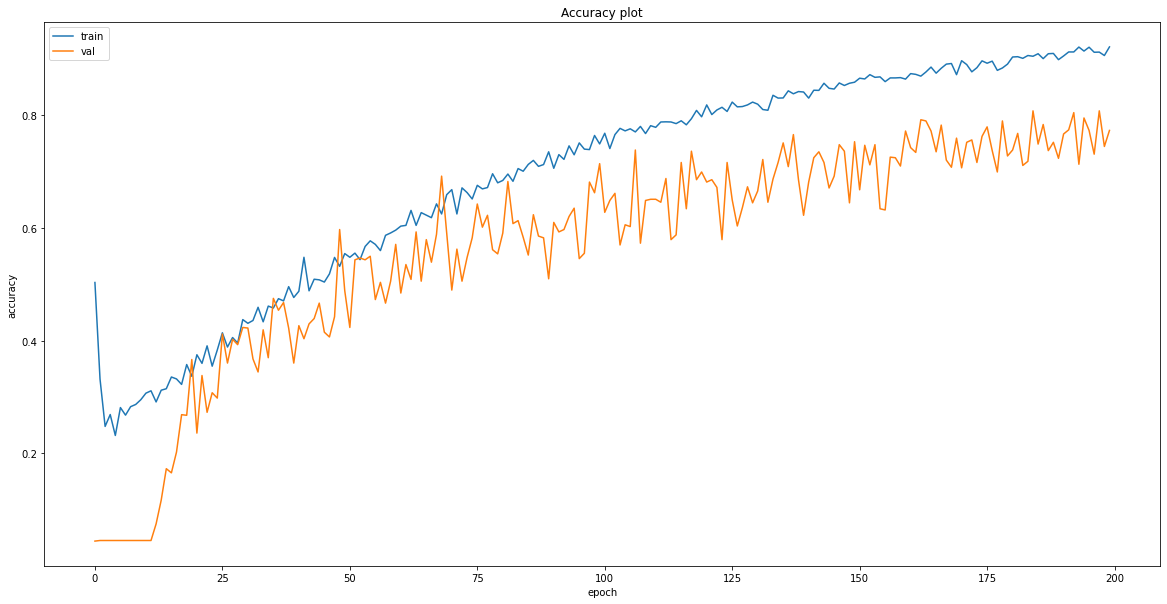

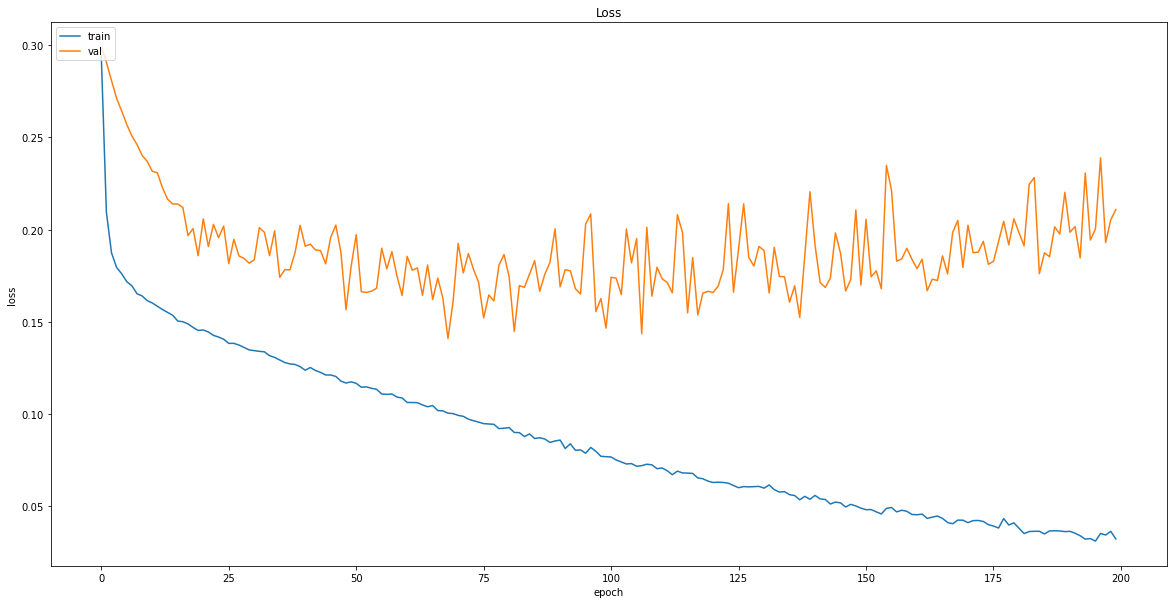

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
# Save model
model.save("models/{}".format('full_cycle_time_series_lstm_buy_hold_sell.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/full_cycle_time_series_lstm_buy_hold_sell.model\assets


### Test Performance

### Accumulation Phase Test Data

In [21]:
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
log  = pd.DataFrame(columns = column_names)
logger = []

In [22]:
seed = 10
df = pd.read_csv("accumulation phase data/test_data.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2004-06-14    93.010002  92.918784 -32.009897  48922600.0     2.0
2004-06-15    91.529999  92.705124 -68.734488  45879300.0     2.0
2004-06-16    90.209999  92.321259 -94.676024  40369000.0     2.0
2004-06-17    89.980003  91.961066 -87.983635  36219100.0     2.0
2004-06-18    89.339996  91.557824 -85.961924  32718400.0     2.0


In [23]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [24]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(248, 15, 4)

In [25]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [26]:
model = tf.keras.models.load_model("models/full_cycle_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

8/8 [==============================] - 0s 3ms/step - loss: 0.1573 - accuracy: 0.7903 - mean_squared_error: 9.0846 - weighted_accuracy: 0.7903 - weighted_mean_squared_error: 9.0846
Test loss: 0.15725727379322052
Test accuracy: 0.7903226017951965


In [27]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 209, 1: 12, 0: 27})

In [28]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 229, 1: 11, 0: 8})

In [29]:
df = pd.read_csv("accumulation phase data/test_data.csv")
df.set_index('Date', inplace=True)

In [30]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2004-07-01,93.650002,92.599542,-13.252981,56757300.0,2.0,2,2
2004-07-02,93.610001,92.761151,-20.080318,52187800.0,2.0,2,2
2004-07-06,92.199997,92.891743,-20.615805,48857200.0,2.0,2,2
2004-07-07,90.570000,92.785321,-39.491353,46253500.0,2.0,2,2
2004-07-08,90.000000,92.444502,-61.311929,41751600.0,2.0,2,2


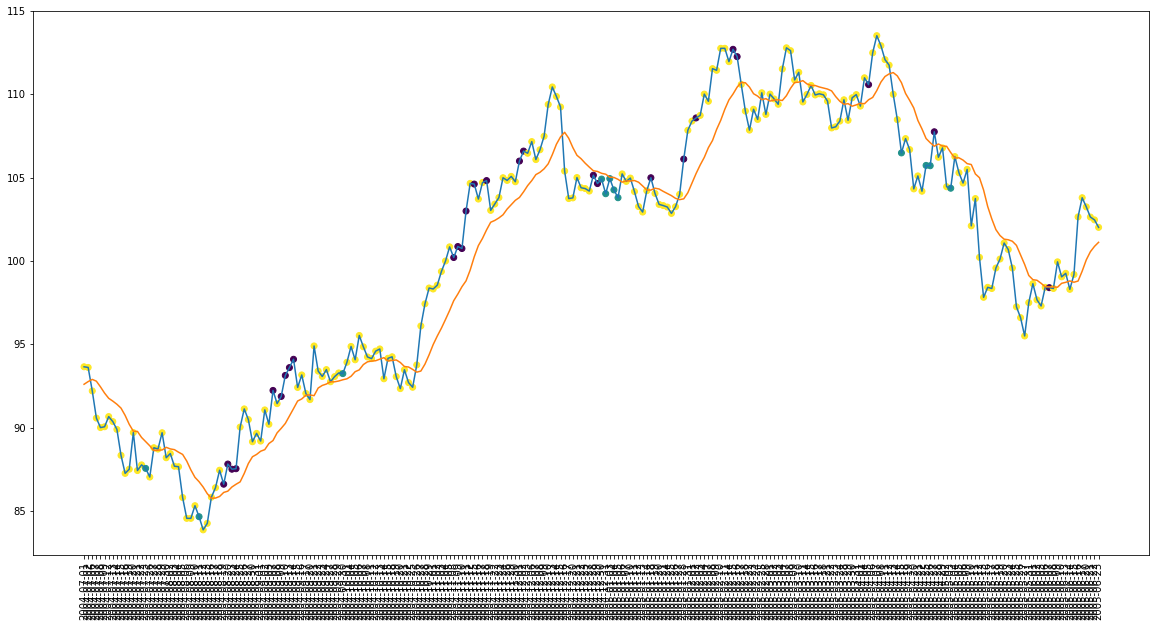

In [31]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [32]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 248
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 2
actual predicted sells: 0
actual sells but predicted hold: 6
actual holds but predicted buy: 8
actual holds but predicted sell: 27
actual predicted holds: 194
Percentage buys correct: 18.181818181818183%
Percentage sells correct: 0.0%
Percentage holds correct: 84.71615720524018%
actual buys: 11
actual sells: 8
actual holds: 229


In [33]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[89.88999938964844, 90.0, 90.05000305175781, 90.36000061035156, 90.56999969482422, 90.66000366210938, 92.1999969482422, 93.61000061035156, 93.6500015258789]
[87.25, 87.41999816894531, 87.5, 87.76000213623047, 88.33000183105469, 89.69999694824219, 89.88999938964844, 90.36000061035156, 90.66000366210938]
Percentage buys correct: 58.333333333333336%
Percentage sells correct: 55.55555555555556%
Percentage holds correct: 82.77511961722487%


In [34]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[89.88999938964844, 90.0, 90.05000305175781, 90.36000061035156, 90.56999969482422, 90.66000366210938, 92.1999969482422, 93.61000061035156, 93.6500015258789]
[87.25, 87.41999816894531, 87.5, 87.76000213623047, 88.33000183105469, 89.69999694824219, 89.88999938964844, 90.36000061035156, 90.66000366210938]
Percentage buys correct: 58.333333333333336%
Percentage sells correct: 55.55555555555556%
Percentage holds correct: 82.77511961722487%


In [35]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $87.55000305175781
Shares owned at the moment: 113
Cash capital at the moment: $79.64349170303285


Stop Loss Activated!

Share price: $84.55000305175781
Shares owned at the moment: 0
Cash capital at the moment: $9607.519923103331


Share price: $84.6500015258789
Shares owned at the moment: 113
Cash capital at the moment: $15.76476270484818


Price increase from previously bought: 8.655717384893302%
Share price: $92.2300033569336
Shares owned at the moment: 0
Cash capital at the moment: $10409.094668495176


Share price: $93.23999786376952
Shares owned at the moment: 111
Cash capital at the moment: $30.993396268844663


Price increase from previously bought: 7.180587340619282%
Share price: $100.20999908447266
Shares owned at the moment: 0
Cash capital at the moment: $11123.714192424774


Share price: $104.91999816894531
Shares owned at the moment: 105
Cash capital at the moment: $76.81873521423222


Price increase from previously bought: 7.1300977700931245%
Share price: $1

In [36]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $10830.181677955627
profit gained: 8.301816779556265%


In [37]:
logger

[0.7903226017951965,
 '18.181818181818183%',
 '0.0%',
 '84.71615720524018%',
 '58.333333333333336%',
 '55.55555555555556%',
 '82.77511961722487%',
 '13.289687821846%',
 '8.301816779556265%']

In [38]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.790323,18.181818181818183%,0.0%,84.71615720524018%,58.333333333333336%,55.55555555555556%,82.77511961722487%,13.289687821846%,8.301816779556265%


### Mark Up Phase Test Data

In [39]:
logger = []

In [40]:
seed = 10
df = pd.read_csv("mark up phase data/test_data.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-22   115.589996  116.459043 -80.074504 -17684500.0     2.0
2020-01-23   116.099998  116.403805 -70.577262 -12758400.0     2.0
2020-01-24   115.809998  116.312450 -69.789236 -17063500.0     2.0
2020-01-27   114.370003  116.013612 -94.416205 -21446900.0     2.0
2020-01-28   115.860001  115.989979 -34.297465 -14428500.0     2.0


In [41]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [42]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(219, 15, 4)

In [43]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [44]:
model = tf.keras.models.load_model("models/full_cycle_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1896 - accuracy: 0.8082 - mean_squared_error: 9.3518 - weighted_accuracy: 0.8082 - weighted_mean_squared_error: 9.3518
Test loss: 0.18959598243236542
Test accuracy: 0.8082191944122314


In [45]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 185, 0: 21, 1: 13})

In [46]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [47]:
df = pd.read_csv("mark up phase data/test_data.csv")
df.set_index('Date', inplace=True)

In [48]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-10,115.250000,115.943088,-17.142986,-11228200.0,2.0,2,2
2020-02-11,115.400002,115.836459,-43.516528,-17373100.0,2.0,2,2
2020-02-12,115.849998,115.769312,-40.219793,-11576300.0,2.0,0,2
2020-02-13,117.440002,115.781725,-30.329757,-6840700.0,2.0,0,2
2020-02-14,117.889999,116.036845,-2.057582,-1507500.0,2.0,2,0


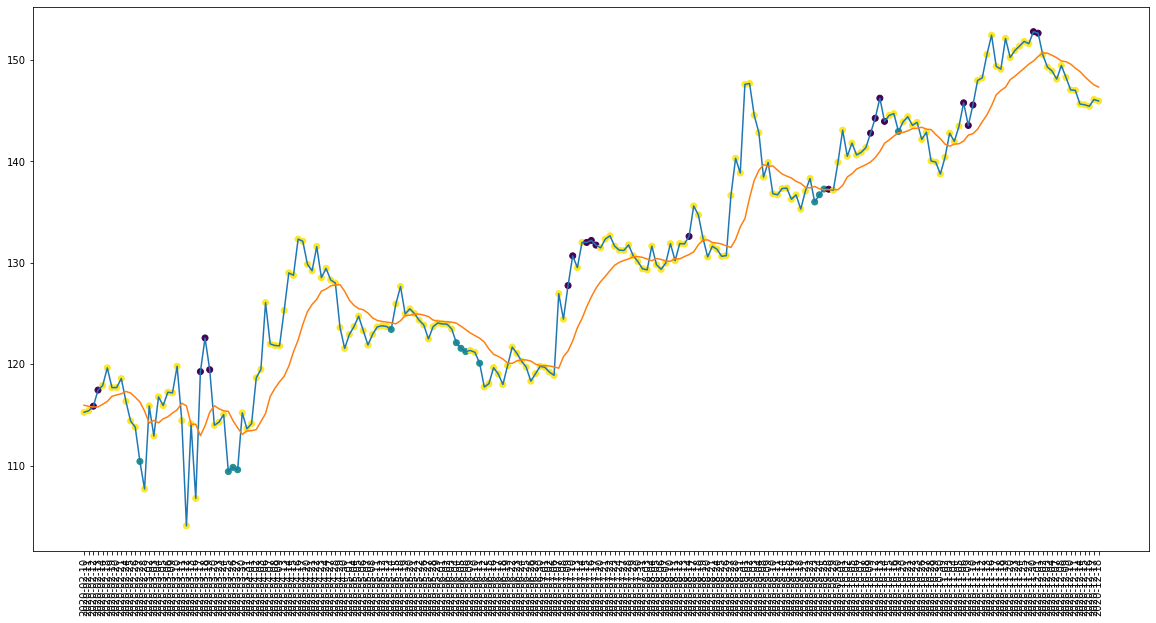

In [49]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [50]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))
logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 8
actual holds but predicted buy: 11
actual holds but predicted sell: 18
actual predicted holds: 172
Percentage buys correct: 28.571428571428573%
Percentage sells correct: 27.272727272727273%
Percentage holds correct: 85.57213930348259%
actual buys: 7
actual sells: 11
actual holds: 201


In [51]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[115.25, 115.4000015258789, 115.8499984741211, 117.44000244140624, 117.68000030517578, 117.69000244140624, 117.88999938964844, 118.58000183105469, 119.62999725341795]
[107.68000030517578, 110.4000015258789, 113.77999877929688, 114.38999938964844, 115.87999725341795, 116.31999969482422, 117.68000030517578, 117.69000244140624, 118.58000183105469]
Percentage buys correct: 69.23076923076923%
Percentage sells correct: 57.142857142857146%
Percentage holds correct: 84.86486486486487%


In [52]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $110.4000015258789
Shares owned at the moment: 90
Cash capital at the moment: $36.67586229324297


Stop Loss Activated!

Share price: $104.0500030517578
Shares owned at the moment: 0
Cash capital at the moment: $9375.423761196134


Share price: $109.4000015258789
Shares owned at the moment: 85
Cash capital at the moment: $50.85138113975336


Price increase from previously bought: 16.453061410354387%
Share price: $127.75
Shares owned at the moment: 0
Cash capital at the moment: $10879.739818639753


Share price: $135.99000549316406
Shares owned at the moment: 79
Cash capital at the moment: $106.98555598640269


Price increase from previously bought: 5.783068305070604%
Share price: $144.25
Shares owned at the moment: 0
Cash capital at the moment: $11471.397243486403


Share price: $142.9499969482422
Shares owned at the moment: 80
Cash capital at the moment: $3.948488298414304


Stop Loss Activated!

Share price: $138.75
Shares owned at the moment: 0
Cash capital at the momen

In [53]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12578.425938270568
profit gained: 25.784259382705677%


In [54]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.790323,18.181818181818183%,0.0%,84.71615720524018%,58.333333333333336%,55.55555555555556%,82.77511961722487%,13.289687821846%,8.301816779556265%
1,0.808219,28.571428571428573%,27.272727272727273%,85.57213930348259%,69.23076923076923%,57.142857142857146%,84.86486486486487%,10.734234882984147%,25.784259382705677%


### Distribution Phase Test Data

In [55]:
logger = []

In [56]:
seed = 10
df = pd.read_csv("distribution phase data/test_data.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14        OBV_7  labels
Date                                                               
2016-12-05   223.360001  213.378658 -16.514565 -283274800.0     2.0
2016-12-06   228.550003  215.712711  -2.667189 -278675500.0     2.0
2016-12-07   231.380005  218.123064  -4.633597 -273416200.0     2.0
2016-12-08   235.559998  220.805669  -1.742271 -266821000.0     2.0
2016-12-09   241.449997  223.981719  -2.918174 -259477300.0     2.0


In [57]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [58]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(470, 15, 4)

In [59]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [60]:
model = tf.keras.models.load_model("models/full_cycle_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

15/15 [==============================] - 0s 3ms/step - loss: 0.2195 - accuracy: 0.7809 - mean_squared_error: 10.5616 - weighted_accuracy: 0.7809 - weighted_mean_squared_error: 10.5616
Test loss: 0.21953292191028595
Test accuracy: 0.7808510661125183


In [61]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 49, 2: 396, 1: 25})

In [62]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 426, 1: 24, 0: 20})

In [63]:
df = pd.read_csv("distribution phase data/test_data.csv")
df.set_index('Date', inplace=True)

In [64]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2016-12-23,240.970001,237.434924,-26.807731,-247920400.0,2.0,0,2
2016-12-27,241.559998,237.978782,-26.032839,-245732900.0,2.0,0,2
2016-12-28,240.649994,238.529738,-26.433792,-243734700.0,2.0,0,2
2016-12-29,238.179993,238.855931,-48.235368,-246787700.0,1.0,2,1
2016-12-30,239.449997,238.751941,-72.451037,-249406700.0,2.0,2,2


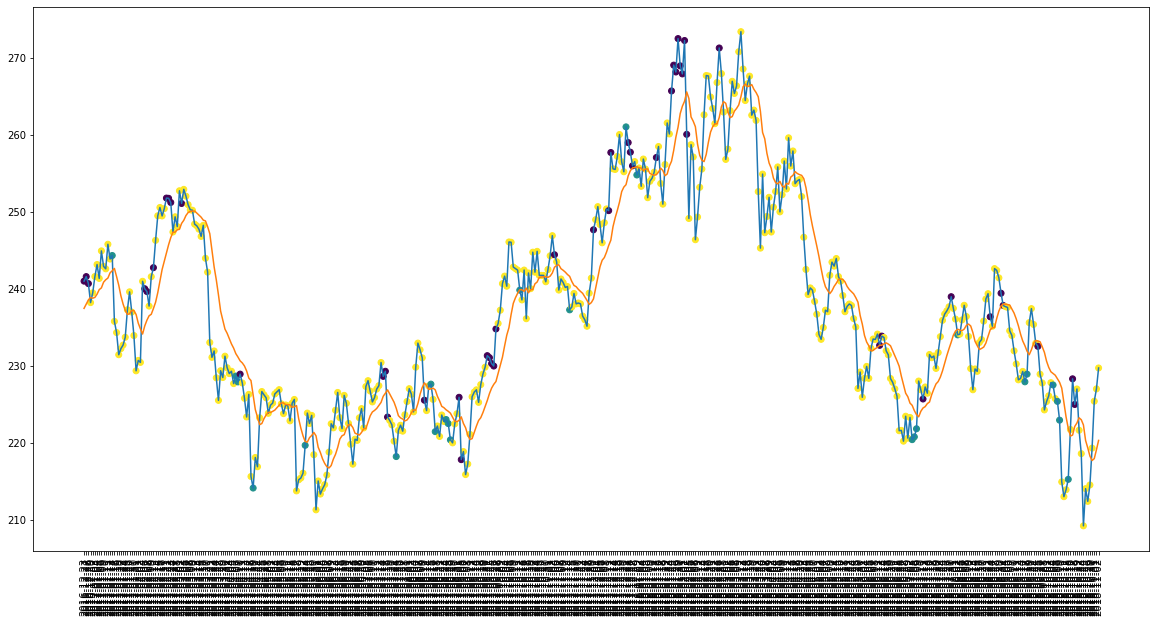

In [65]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

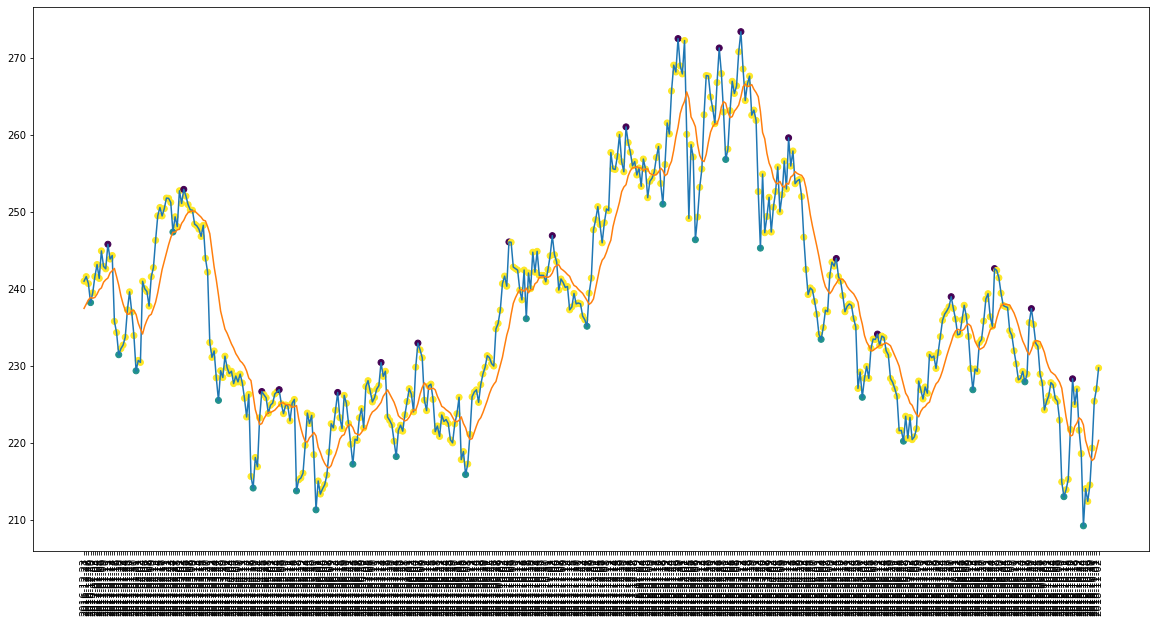

In [66]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [67]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 470
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 21
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 15
actual holds but predicted buy: 21
actual holds but predicted sell: 45
actual predicted holds: 360
Percentage buys correct: 12.5%
Percentage sells correct: 20.0%
Percentage holds correct: 84.50704225352112%
actual buys: 24
actual sells: 20
actual holds: 426


In [68]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[238.17999267578125, 239.4499969482422, 240.6499938964844, 240.97000122070312, 241.32000732421875, 241.55999755859366, 241.57000732421875, 243.1300048828125, 244.8999938964844]
[235.7400054931641, 241.32000732421875, 242.57000732421875, 242.88999938964844, 243.1300048828125, 243.83999633789062, 244.3000030517578, 244.8999938964844, 245.75999450683602]
Percentage buys correct: 56.0%
Percentage sells correct: 55.10204081632653%
Percentage holds correct: 85.0632911392405%


In [69]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $244.3000030517578
Shares owned at the moment: 40
Cash capital at the moment: $201.1268775939934


Stop Loss Activated!

Share price: $235.7400054931641
Shares owned at the moment: 0
Cash capital at the moment: $9604.79569671631


Share price: $228.63999938964844
Shares owned at the moment: 41
Cash capital at the moment: $204.77656180954


Stop Loss Activated!

Share price: $215.58999633789062
Shares owned at the moment: 0
Cash capital at the moment: $9019.658639575959


Share price: $214.08999633789062
Shares owned at the moment: 42
Cash capital at the moment: $3.1513988075257657


Price increase from previously bought: 6.4846952369262745%
Share price: $228.6000061035156
Shares owned at the moment: 0
Cash capital at the moment: $9577.948354450224


Share price: $218.17999267578125
Shares owned at the moment: 43
Cash capital at the moment: $170.4088852577188


Price increase from previously bought: 5.718075846216775%
Share price: $231.2899932861328
Shares owned at the mome

In [70]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9484.453134635925
profit gained: -5.155468653640746%


In [71]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.790323,18.181818181818183%,0.0%,84.71615720524018%,58.333333333333336%,55.55555555555556%,82.77511961722487%,13.289687821846%,8.301816779556265%
1,0.808219,28.571428571428573%,27.272727272727273%,85.57213930348259%,69.23076923076923%,57.142857142857146%,84.86486486486487%,10.734234882984147%,25.784259382705677%
2,0.780851,12.5%,20.0%,84.50704225352112%,56.0%,55.10204081632653%,85.0632911392405%,6.861832133293102%,-5.155468653640746%


### Mark Down Phase Test Data

In [72]:
logger = []

In [73]:
seed = 10
df = pd.read_csv("mark down phase data/test_data.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14        OBV_7  labels
Date                                                               
2007-10-01   216.740005  205.638670  -5.220429  161688200.0     2.0
2007-10-02   222.979996  208.306567  -1.526716  171593800.0     2.0
2007-10-03   228.020004  211.339403  -1.071898  181013600.0     2.0
2007-10-04   227.350006  213.802573  -7.282412  170892200.0     2.0
2007-10-05   225.949997  215.671407 -10.566735  160852300.0     2.0


In [74]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [75]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(278, 15, 4)

In [76]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [77]:
model = tf.keras.models.load_model("models/full_cycle_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

9/9 [==============================] - 0s 3ms/step - loss: 0.2042 - accuracy: 0.8165 - mean_squared_error: 11.5165 - weighted_accuracy: 0.8165 - weighted_mean_squared_error: 11.5165
Test loss: 0.2042008489370346
Test accuracy: 0.8165467381477356


In [78]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 239, 1: 23, 0: 16})

In [79]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({1: 16, 2: 249, 0: 13})

In [80]:
df = pd.read_csv("mark down phase data/test_data.csv")
df.set_index('Date', inplace=True)

In [81]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2007-10-19,217.690002,226.848008,-48.765388,164382100.0,1.0,2,1
2007-10-22,222.179993,225.439084,-99.592777,151275300.0,2.0,2,2
2007-10-23,223.759995,224.937685,-65.618001,163438800.0,2.0,2,2
2007-10-24,225.119995,224.756502,-59.700390,171615400.0,2.0,2,2
2007-10-25,226.660004,224.812424,-54.606755,184266200.0,2.0,2,2


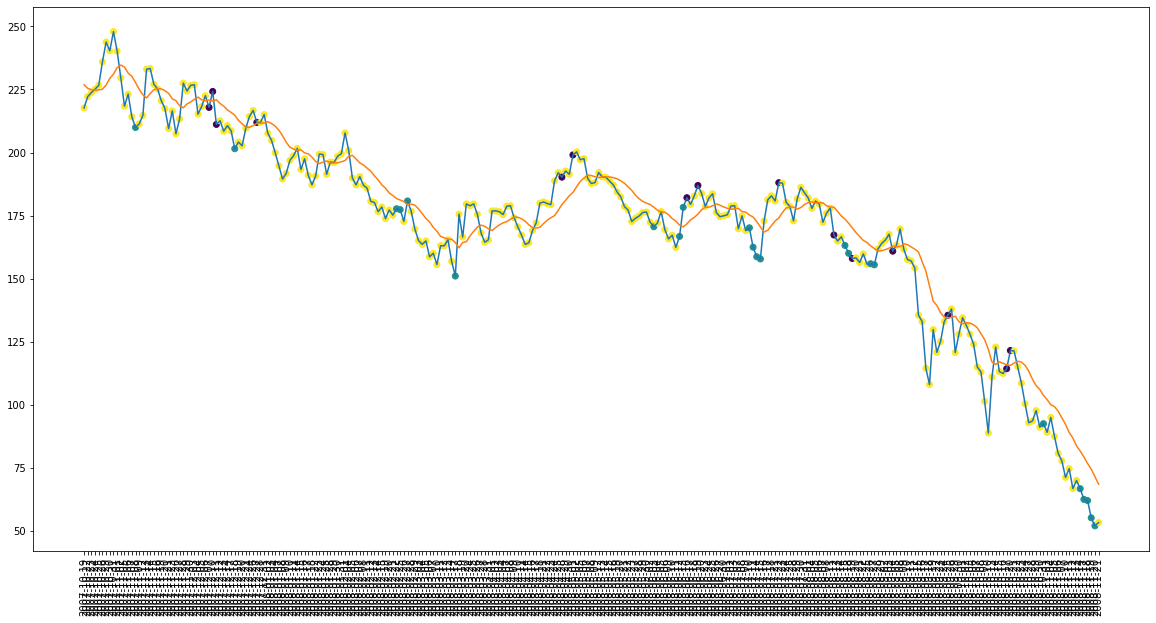

In [82]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

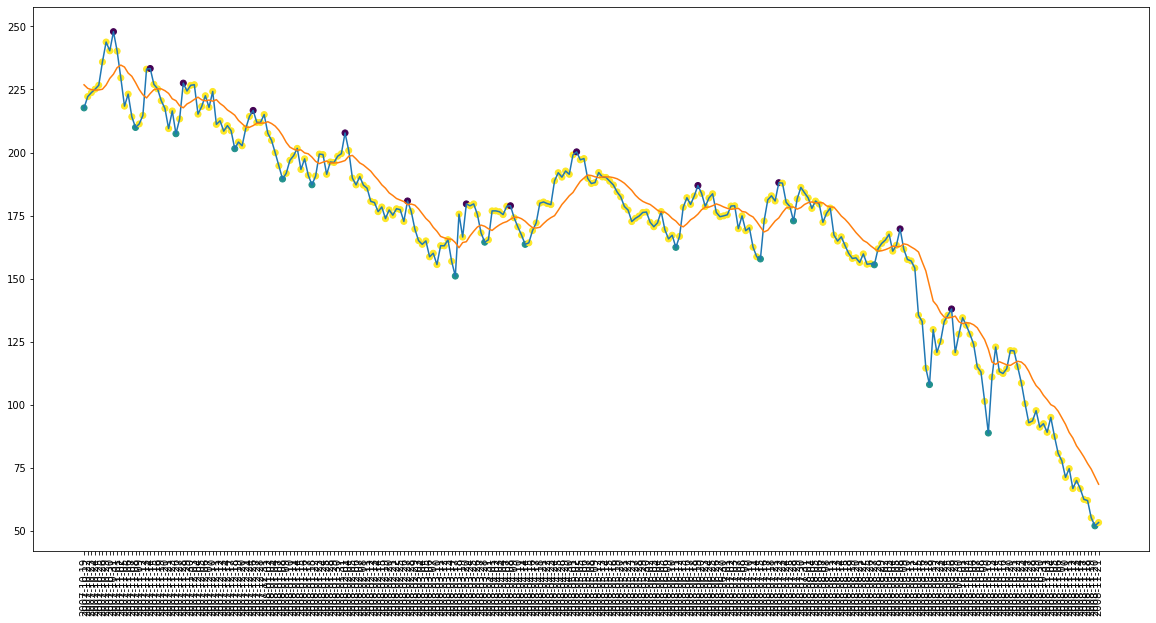

In [83]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [84]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 278
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 10
actual holds but predicted buy: 16
actual holds but predicted sell: 14
actual predicted holds: 219
Percentage buys correct: 37.5%
Percentage sells correct: 15.384615384615385%
Percentage holds correct: 87.95180722891567%
actual buys: 16
actual sells: 13
actual holds: 249


In [85]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[217.69000244140625, 222.17999267578125, 223.75999450683602, 225.1199951171875, 226.66000366210938, 235.9199981689453, 240.3300018310547, 243.80999755859366, 247.9199981689453]
[209.94000244140625, 214.17999267578125, 218.38999938964844, 223.16000366210938, 229.6000061035156, 240.2100067138672, 240.3300018310547, 243.80999755859366, 247.9199981689453]
Percentage buys correct: 56.52173913043478%
Percentage sells correct: 53.333333333333336%
Percentage holds correct: 84.93723849372385%


In [86]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $209.94000244140625
Shares owned at the moment: 47
Cash capital at the moment: $105.68513993835404


Price increase from previously bought: 6.504295290700934%
Share price: $224.2100067138672
Shares owned at the moment: 0
Cash capital at the moment: $10614.576312122344


Share price: $201.50999450683602
Shares owned at the moment: 52
Cash capital at the moment: $107.24066855239471


Stop Loss Activated!

Share price: $194.72999572753903
Shares owned at the moment: 0
Cash capital at the moment: $10205.354056995386


Share price: $177.7100067138672
Shares owned at the moment: 57
Cash capital at the moment: $48.02763075255643


Stop Loss Activated!

Share price: $172.6999969482422
Shares owned at the moment: 0
Cash capital at the moment: $9864.856732280723


Share price: $180.8000030517578
Shares owned at the moment: 54
Cash capital at the moment: $74.80776703261472


Stop Loss Activated!

Share price: $169.6300048828125
Shares owned at the moment: 0
Cash capital at the moment

In [87]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $2569.3637014627457
profit gained: -74.30636298537254%


In [88]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.790323,18.181818181818183%,0.0%,84.71615720524018%,58.333333333333336%,55.55555555555556%,82.77511961722487%,13.289687821846%,8.301816779556265%
1,0.808219,28.571428571428573%,27.272727272727273%,85.57213930348259%,69.23076923076923%,57.142857142857146%,84.86486486486487%,10.734234882984147%,25.784259382705677%
2,0.780851,12.5%,20.0%,84.50704225352112%,56.0%,55.10204081632653%,85.0632911392405%,6.861832133293102%,-5.155468653640746%
3,0.816547,37.5%,15.384615384615385%,87.95180722891567%,56.52173913043478%,53.333333333333336%,84.93723849372385%,-17.94720398633013%,-74.30636298537254%


### bull phase test data

In [89]:
logger = []

In [90]:
seed = 10
df = pd.read_csv("bull phase data/test_data.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d       EMA_12   willr_14       OBV_7  labels
Date                                                               
2020-01-22  1075.300049  1097.577291 -89.711935   1200864.0     2.0
2020-01-23  1075.510010  1094.182325 -70.779503   4820868.0     2.0
2020-02-03  1052.800049  1087.815821 -81.895216   -525975.0     1.0
2020-02-04  1003.919983  1074.908769 -83.419991 -12870263.0     2.0
2020-02-05  1038.010010  1069.232037 -59.790669  -6607845.0     2.0


In [91]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(208, 15, 4)

In [92]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [93]:
model = tf.keras.models.load_model("models/full_cycle_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2392 - accuracy: 0.7596 - mean_squared_error: 9.6134 - weighted_accuracy: 0.7596 - weighted_mean_squared_error: 9.6134
Test loss: 0.23915456235408783
Test accuracy: 0.7596153616905212


In [94]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 37, 2: 166, 1: 5})

In [95]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [96]:
df = pd.read_csv("bull phase data/test_data.csv")
df.set_index('Date', inplace=True)

In [97]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-19,1096.500000,1082.513705,-22.324305,-423291.0,2.0,0,2
2020-02-20,1118.000000,1084.665443,-12.988283,3281856.0,0.0,0,0
2020-02-21,1112.880005,1089.793836,-4.166667,7962118.0,2.0,2,2
2020-02-24,1087.180054,1093.345554,-10.201830,5068110.0,2.0,0,2
2020-02-25,1074.810059,1092.397016,-40.474836,1203074.0,2.0,2,2


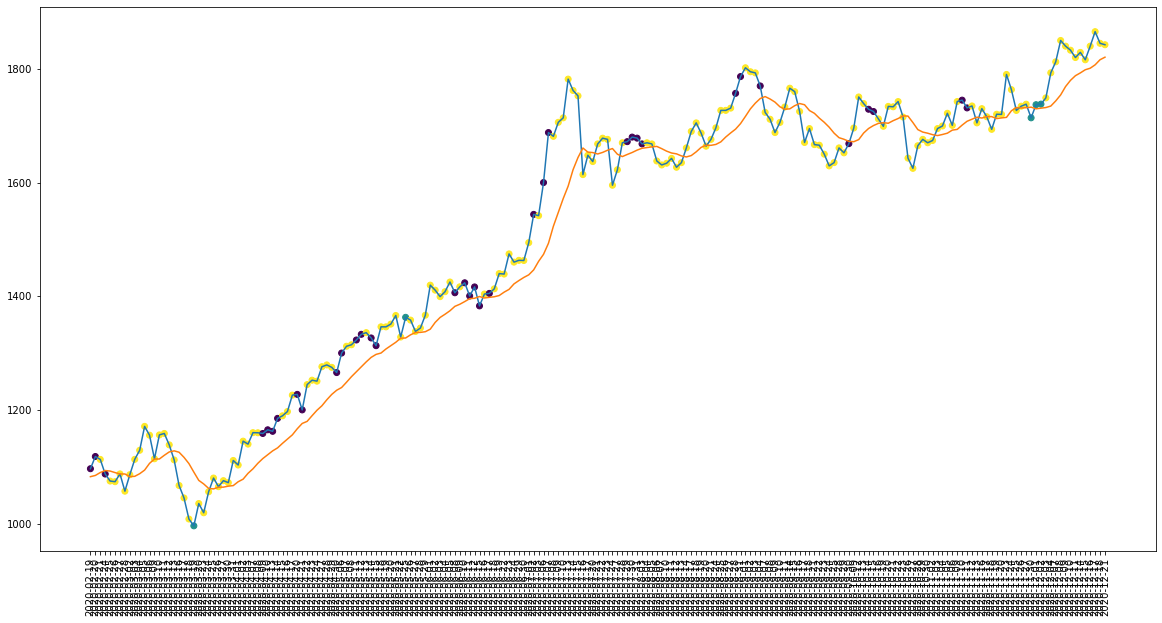

In [98]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

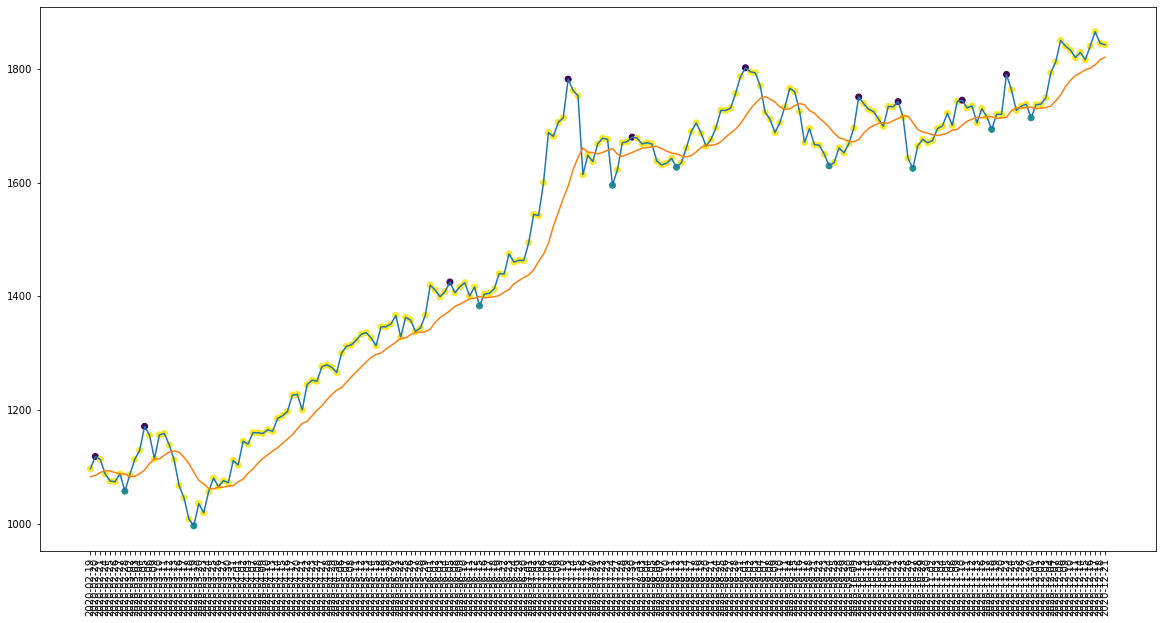

In [99]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [100]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 208
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 3
actual holds but predicted sell: 33
actual predicted holds: 153
Percentage buys correct: 22.22222222222222%
Percentage sells correct: 30.0%
Percentage holds correct: 80.95238095238095%
actual buys: 9
actual sells: 10
actual holds: 189


In [101]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[1057.0, 1073.699951171875, 1074.81005859375, 1086.010009765625, 1087.1800537109377, 1087.3900146484377, 1096.5, 1112.8800048828123, 1118.0]
[1057.0, 1086.010009765625, 1087.3900146484377, 1113.0, 1114.010009765625, 1128.9200439453125, 1155.5, 1156.0, 1171.0]
Percentage buys correct: 60.0%
Percentage sells correct: 47.22222222222222%
Percentage holds correct: 85.5421686746988%


In [102]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $996.0
Shares owned at the moment: 10
Cash capital at the moment: $12.610000000000582


Price increase from previously bought: 15.996271298106901%
Share price: $1158.5
Shares owned at the moment: 0
Cash capital at the moment: $11565.75125


Share price: $1362.9000244140625
Shares owned at the moment: 8
Cash capital at the moment: $632.56725415039


Price increase from previously bought: 12.977152901560917%
Share price: $1544.0
Shares owned at the moment: 0
Cash capital at the moment: $12950.59925415039


Share price: $1713.9100341796875
Shares owned at the moment: 7
Cash capital at the moment: $920.2362467346175




Capital at the end of test period: $13782.268121734616
profit gained: 37.82268121734616%


In [103]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16641.259749999997
profit gained: 66.41259749999998%


In [104]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.790323,18.181818181818183%,0.0%,84.71615720524018%,58.333333333333336%,55.55555555555556%,82.77511961722487%,13.289687821846%,8.301816779556265%
1,0.808219,28.571428571428573%,27.272727272727273%,85.57213930348259%,69.23076923076923%,57.142857142857146%,84.86486486486487%,10.734234882984147%,25.784259382705677%
2,0.780851,12.5%,20.0%,84.50704225352112%,56.0%,55.10204081632653%,85.0632911392405%,6.861832133293102%,-5.155468653640746%
3,0.816547,37.5%,15.384615384615385%,87.95180722891567%,56.52173913043478%,53.333333333333336%,84.93723849372385%,-17.94720398633013%,-74.30636298537254%
4,0.759615,22.22222222222222%,30.0%,80.95238095238095%,60.0%,47.22222222222222%,85.5421686746988%,37.82268121734616%,66.41259749999998%


### bear phase test data

In [105]:
logger = []

In [106]:
seed = 10
df = pd.read_csv("bear phase data/test_data.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2018-01-22    32.830002  32.653718 -49.494874  128764966.0     2.0
2018-01-23    33.750000  32.822377 -18.518497  165063463.0     2.0
2018-01-24    33.970001  32.998934 -16.190425  201240854.0     2.0
2018-01-25    33.959999  33.146790 -17.627141  173336178.0     2.0
2018-01-26    34.880001  33.413438  -2.648942  221767625.0     0.0


In [107]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(595, 15, 4)

In [108]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [109]:
model = tf.keras.models.load_model("models/full_cycle_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

19/19 [==============================] - 0s 3ms/step - loss: 0.2250 - accuracy: 0.7176 - mean_squared_error: 9.1341 - weighted_accuracy: 0.7176 - weighted_mean_squared_error: 9.1341
Test loss: 0.2249576598405838
Test accuracy: 0.7176470756530762


In [110]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 470, 1: 64, 0: 61})

In [111]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [112]:
df = pd.read_csv("bear phase data/test_data.csv")
df.set_index('Date', inplace=True)

In [113]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2018-02-09,32.009998,33.951521,-90.236635,104835489.0,1.0,2,1
2018-02-12,32.320000,33.652826,-74.280269,68354718.0,2.0,2,2
2018-02-13,32.919998,33.447775,-68.330148,85359125.0,2.0,1,2
2018-02-14,33.209999,33.366579,-56.813864,101567392.0,2.0,2,2
2018-02-22,34.020000,33.342490,-51.247629,113719002.0,2.0,2,2


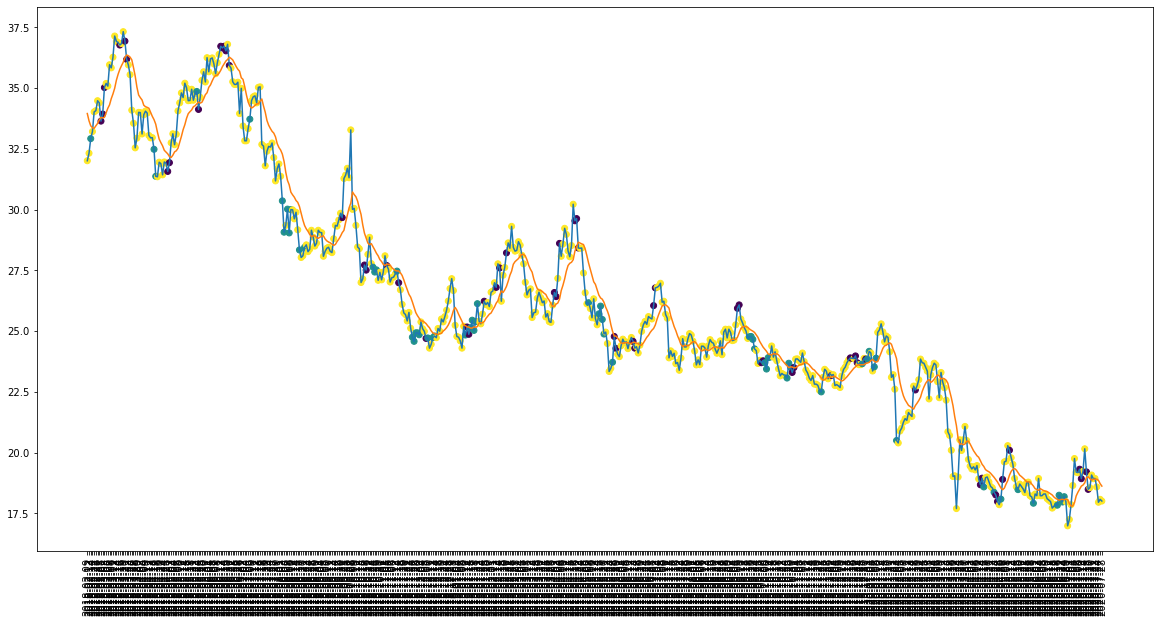

In [114]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

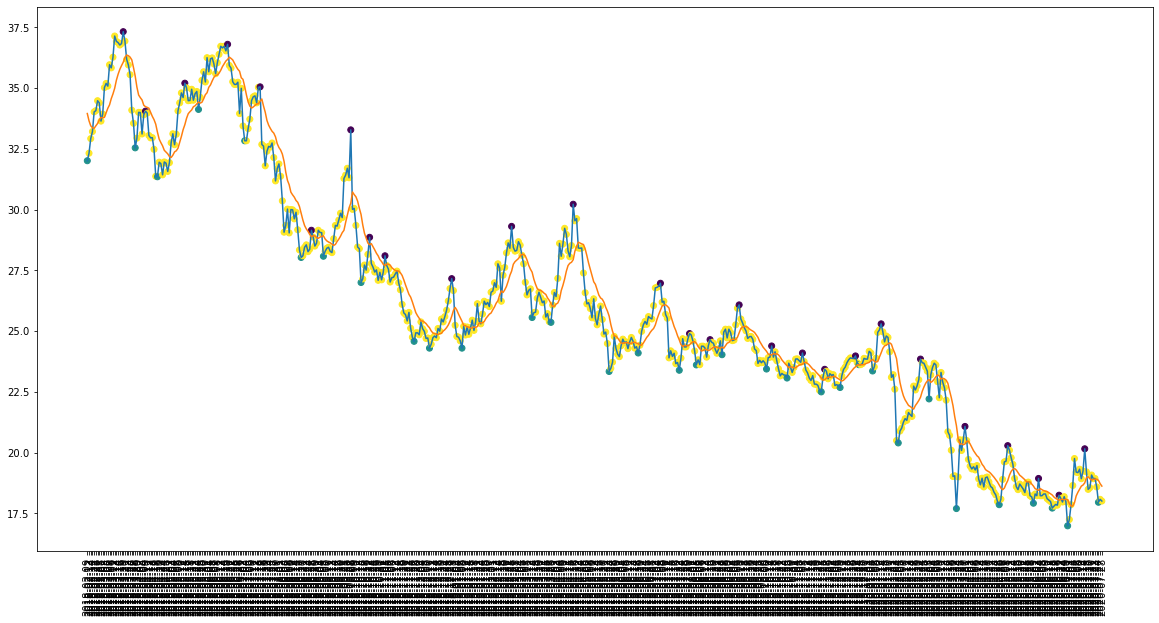

In [115]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [116]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 595
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 26
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 24
actual holds but predicted buy: 58
actual holds but predicted sell: 58
actual predicted holds: 420
Percentage buys correct: 15.625%
Percentage sells correct: 7.407407407407407%
Percentage holds correct: 78.35820895522389%
actual buys: 32
actual sells: 27
actual holds: 536


In [117]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[32.009998321533196, 32.31999969482422, 32.919998168945305, 33.209999084472656, 33.639999389648445, 34.02000045776367, 34.06999969482422, 34.389999389648445, 34.47999954223633]
[33.639999389648445, 33.93000030517578, 34.389999389648445, 34.47999954223633, 35.02000045776367, 35.080001831054695, 35.189998626708984, 35.83000183105469, 35.959999084472656]
Percentage buys correct: 46.875%
Percentage sells correct: 40.98360655737705%
Percentage holds correct: 82.30277185501066%


In [118]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $32.919998168945305
Shares owned at the moment: 302
Cash capital at the moment: $30.820494499208507


Price increase from previously bought: 6.087367896314677%
Share price: $35.02000045776367
Shares owned at the moment: 0
Cash capital at the moment: $10577.776522363665


Share price: $32.47999954223633
Shares owned at the moment: 324
Cash capital at the moment: $25.316991086961934


Stop Loss Activated!

Share price: $31.3700008392334
Shares owned at the moment: 0
Cash capital at the moment: $10161.246592250825


Share price: $31.3700008392334
Shares owned at the moment: 323
Cash capital at the moment: $0.8719179329891631


Price increase from previously bought: 8.468043829680028%
Share price: $34.11999893188477
Shares owned at the moment: 0
Cash capital at the moment: $10991.324483880524


Share price: $33.720001220703125
Shares owned at the moment: 325
Cash capital at the moment: $2.1868360610042146


Stop Loss Activated!

Share price: $32.68000030517578
Shares owned at 

In [119]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5603.220989425184
profit gained: -43.967790105748165%


In [120]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.790323,18.181818181818183%,0.0%,84.71615720524018%,58.333333333333336%,55.55555555555556%,82.77511961722487%,13.289687821846%,8.301816779556265%
1,0.808219,28.571428571428573%,27.272727272727273%,85.57213930348259%,69.23076923076923%,57.142857142857146%,84.86486486486487%,10.734234882984147%,25.784259382705677%
2,0.780851,12.5%,20.0%,84.50704225352112%,56.0%,55.10204081632653%,85.0632911392405%,6.861832133293102%,-5.155468653640746%
3,0.816547,37.5%,15.384615384615385%,87.95180722891567%,56.52173913043478%,53.333333333333336%,84.93723849372385%,-17.94720398633013%,-74.30636298537254%
4,0.759615,22.22222222222222%,30.0%,80.95238095238095%,60.0%,47.22222222222222%,85.5421686746988%,37.82268121734616%,66.41259749999998%


### Full Cycle Test Data

In [121]:
logger = []

In [122]:
seed = 10
df = pd.read_csv("full cycle data/test_data.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2002-11-11         8.74  8.763110 -71.929852 -553467352.0     2.0
2002-11-12         8.50  8.722632 -80.487816 -559735252.0     2.0
2002-11-13         8.63  8.708381 -69.918697 -552295352.0     2.0
2002-11-14         8.52  8.679399 -78.861762 -566378552.0     2.0
2002-11-15         8.80  8.697953 -56.097548 -558353452.0     2.0


In [123]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(917, 15, 4)

In [124]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [125]:
model = tf.keras.models.load_model("models/full_cycle_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

29/29 [==============================] - 0s 3ms/step - loss: 0.2235 - accuracy: 0.7699 - mean_squared_error: 9.4920 - weighted_accuracy: 0.7699 - weighted_mean_squared_error: 9.4920
Test loss: 0.22350583970546722
Test accuracy: 0.7699018716812134


In [126]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 764, 1: 85, 0: 68})

In [127]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [128]:
df = pd.read_csv("full cycle data/test_data.csv")
df.set_index('Date', inplace=True)

In [129]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2002-12-02,11.45,10.087284,-3.883491,-531653852.0,0.0,2,0
2002-12-03,9.96,10.296932,-13.142858,-519461852.0,2.0,2,2
2002-12-04,10.15,10.245097,-55.714280,-548693152.0,2.0,2,2
2002-12-05,10.02,10.230466,-51.764718,-529235552.0,2.0,2,2
2002-12-06,9.88,10.198087,-55.588224,-540995752.0,2.0,2,2


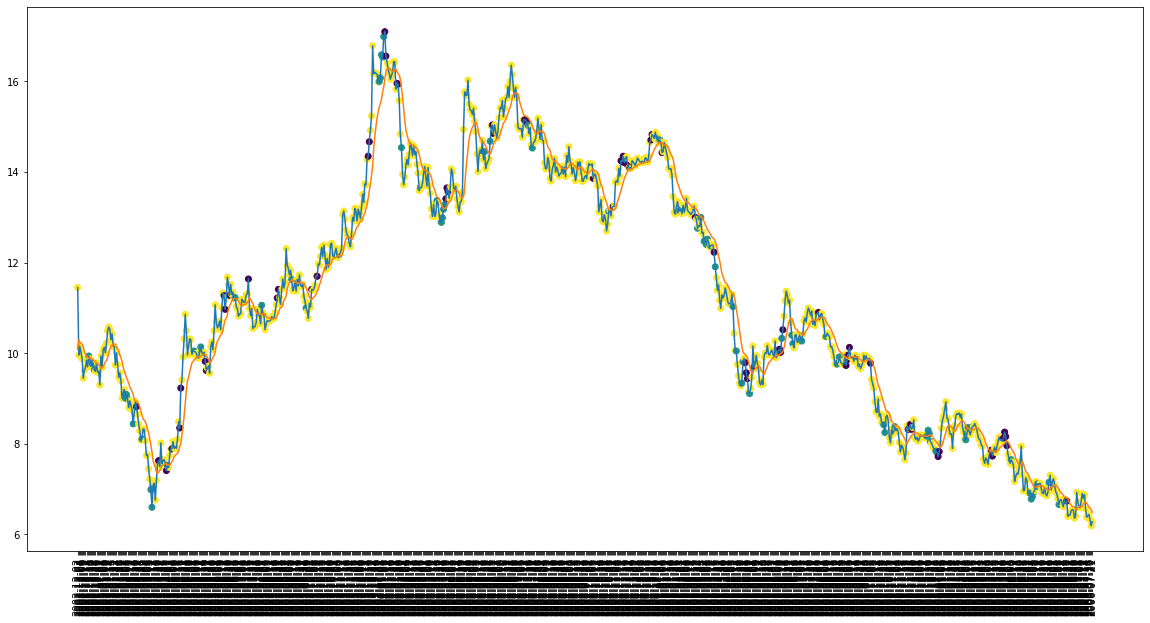

In [130]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

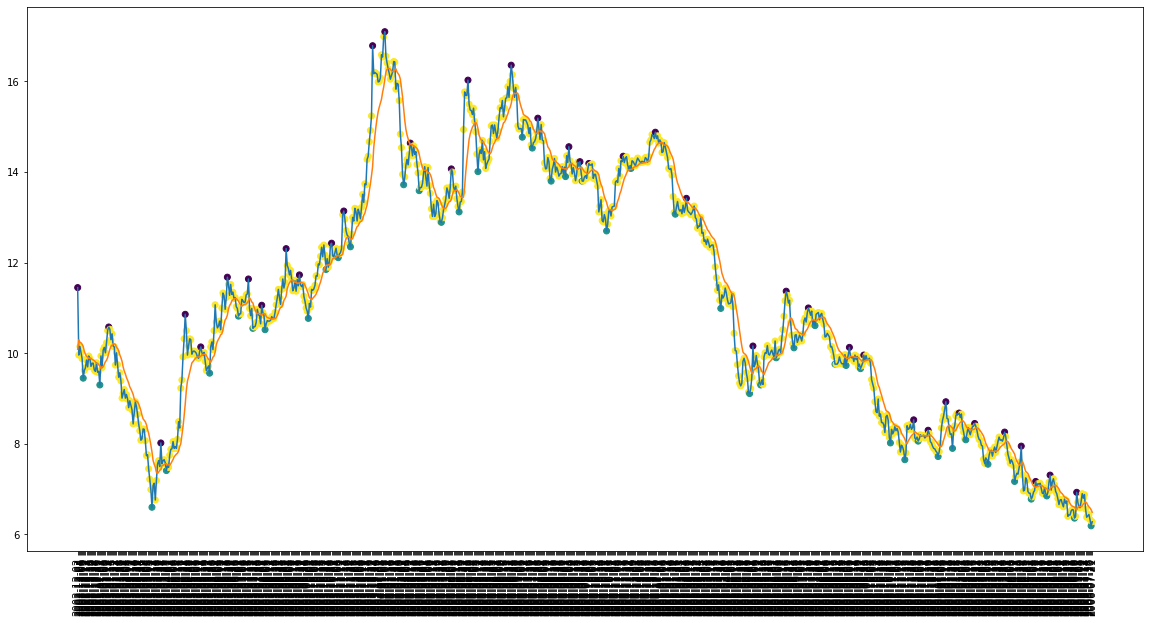

In [131]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [132]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 917
actual predicted buys: 6
actual buys but predicted sell: 3
actual buys but predicted hold: 37
actual sells but predicted buy: 3
actual predicted sells: 5
actual sells but predicted hold: 32
actual holds but predicted buy: 76
actual holds but predicted sell: 60
actual predicted holds: 695
Percentage buys correct: 13.043478260869565%
Percentage sells correct: 12.5%
Percentage holds correct: 83.63417569193743%
actual buys: 46
actual sells: 40
actual holds: 831


In [133]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[9.449999809265137, 9.619999885559082, 9.68000030517578, 9.850000381469727, 9.880000114440918, 9.960000038146973, 10.020000457763672, 10.149999618530273, 11.449999809265135]
[9.619999885559082, 9.68000030517578, 9.699999809265137, 9.710000038146973, 9.779999732971193, 9.779999732971193, 9.850000381469727, 9.880000114440918, 9.9399995803833]
Percentage buys correct: 45.88235294117647%
Percentage sells correct: 44.11764705882353%
Percentage holds correct: 84.66579292267366%


In [134]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $9.9399995803833
Shares owned at the moment: 1003
Cash capital at the moment: $2.7634170329565677


Stop Loss Activated!

Share price: $9.630000114440918
Shares owned at the moment: 0
Cash capital at the moment: $9635.09158400154


Share price: $9.630000114440918
Shares owned at the moment: 997
Cash capital at the moment: $7.578417090177027


Stop Loss Activated!

Share price: $9.300000190734863
Shares owned at the moment: 0
Cash capital at the moment: $9254.180331729887


Share price: $9.010000228881836
Shares owned at the moment: 1024
Cash capital at the moment: $2.567936710354843


Stop Loss Activated!

Share price: $8.75
Shares owned at the moment: 0
Cash capital at the moment: $8937.927936710355


Share price: $8.439999580383299
Shares owned at the moment: 1056
Cash capital at the moment: $0.7786210441590811


Stop Loss Activated!

Share price: $8.079999923706055
Shares owned at the moment: 0
Cash capital at the moment: $8509.79422069931


Share price: $8.109999656677

In [135]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5459.681323426963
profit gained: -45.40318676573037%


In [136]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.790323,18.181818181818183%,0.0%,84.71615720524018%,58.333333333333336%,55.55555555555556%,82.77511961722487%,13.289687821846%,8.301816779556265%
1,0.808219,28.571428571428573%,27.272727272727273%,85.57213930348259%,69.23076923076923%,57.142857142857146%,84.86486486486487%,10.734234882984147%,25.784259382705677%
2,0.780851,12.5%,20.0%,84.50704225352112%,56.0%,55.10204081632653%,85.0632911392405%,6.861832133293102%,-5.155468653640746%
3,0.816547,37.5%,15.384615384615385%,87.95180722891567%,56.52173913043478%,53.333333333333336%,84.93723849372385%,-17.94720398633013%,-74.30636298537254%
4,0.759615,22.22222222222222%,30.0%,80.95238095238095%,60.0%,47.22222222222222%,85.5421686746988%,37.82268121734616%,66.41259749999998%
5,0.717647,15.625%,7.407407407407407%,78.35820895522389%,46.875%,40.98360655737705%,82.30277185501066%,-15.153156402754794%,-43.967790105748165%
6,0.769902,13.043478260869565%,12.5%,83.63417569193743%,45.88235294117647%,44.11764705882353%,84.66579292267366%,-44.47207820771837%,-45.40318676573037%


In [137]:
experiment

'Full Cycle LSTM Time Series'

In [138]:
if not os.path.exists('{}.csv'.format(experiment)):
            log.to_csv('{}.csv'.format(experiment))